In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def generate_random_num(num, low, high):
    random_numbers = []
    for i in range(num):
        random_numbers.append(random.randint(low,high))
    return np.asarray(random_numbers).reshape(num,1)

'''
def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])
'''

def calculateDistance(x1,y1,x2,y2):
    dist =np.sqrt((x2-x1)**2 + (y2-y1)**2)
    return dist

def calculate_total_distance(sequence_id):
    total_distance = 0
    count = 0
    for i in range(len(sequence_id)-1):
        start_id = sequence_id[i]
        next_id = sequence_id[i+1]
        x1 = np.asarray(cities[cities['CityId']==start_id]['X']).ravel()[0]
        y1 = np.asarray(cities[cities['CityId']==start_id]['Y']).ravel()[0]
        x2 = np.asarray(cities[cities['CityId']==next_id]['X']).ravel()[0]
        y2 = np.asarray(cities[cities['CityId']==next_id]['Y']).ravel()[0]
        dist = calculateDistance(x1,y1,x2,y2)
        prime_city = cities[cities['CityId']==start_id]['is_prime'].ravel()[0]
        if i%10 == 0 and prime_city == False:
            dist = dist*1.1
        else:
            dist = dist
        total_distance += dist
        count += 1
        if count%10000==0:
            print(count)        
    return total_distance

flatten = lambda l: sum(map(flatten, l), []) if isinstance(l, list) else [l]

def is_prime(n):
    if n > 2:
        i = 2
        while i ** 2 <= n:
            if n % i:
                i += 1
            else:
                return False
    elif n != 2:
        return False
    return True

def check_direction(id_current, id_back1, id_back2):
    x0, y0 = data[id_current][0], data[id_current][1]
    x1, y1 = data[id_back1][0], data[id_back1][1]
    x2, y2 = data[id_back2][0], data[id_back2][1]
    dist =(x0-x1) + (y0-y1) + (x1-x2) + (y1-y2)
    return dist

In [3]:
def batch_sequence_update(initial_seq, data, k):
    batch_total = int(len(initial_seq)/k)

    new_seq = [0]
    for i in range(batch_total+1):
        start_num = len(new_seq)
        remaining_id = len(np.asarray(initial_seq[start_num:]))
    
        if remaining_id <= k:
            batch_ids = np.asarray(initial_seq[start_num:-1])
            k = remaining_id-1
        else:
            batch_ids = np.asarray(initial_seq[start_num:start_num+k])
            k = k
        if len(batch_ids)==0:
            continue
        
        batch_seq = shuffle_batch(batch_ids, data, new_seq, k)
        for id_num in batch_seq:
            new_seq.append(id_num)
        if remaining_id <= k:
            break
            
    new_seq = np.asarray(new_seq)
    updated_seq = np.append(new_seq, 0)
    return updated_seq

In [4]:
import random
import itertools
def shuffle_batch(batch_ids, data, new_seq, k):
    permutations = list(itertools.permutations(range(k)))
    permutations = np.asarray(permutations)

    start_coord = data[new_seq[-1]]
    next_batch_coord = data[initial_seq[len(new_seq)+k]]

    batch_coord = []
    for ids in batch_ids:
        batch_coord.append(data[ids])
    
    total_distance = []
    shuffled_sequence = []
    
    for perm in permutations:
        shuffled_sequence.append(perm)
        distances = []  
        dist_start = calculateDistance(start_coord[0], start_coord[1], batch_coord[perm[0]][0], batch_coord[perm[0]][1])
        dist_last = calculateDistance(batch_coord[perm[-1]][0], batch_coord[perm[-1]][1], next_batch_coord[0], next_batch_coord[1])
        distances.append(dist_start)
        distances.append(dist_last)

        for j in range(len(perm)-1):       
            dist = calculateDistance(batch_coord[perm[j]][0], batch_coord[perm[j]][1], batch_coord[perm[j+1]][0], batch_coord[perm[j+1]][1])
            distances.append(dist)
        total_distance.append(np.sum(distances))
        
    min_lenght = np.asarray(total_distance).min()  
    best_seq = np.asarray(shuffled_sequence)[np.argmin(total_distance)]
    
    id_seq = []
    for i in best_seq:
        id_match = batch_ids[i]
        id_seq.append(id_match)
    
    return id_seq


In [5]:
def data_distance_shuffle(data):
    data_loc = data[1:-1]
    index = []
    dist_rec = []
    count = 0
    for coord in data_loc:
        dist_from_start = calculateDistance(data[0][0], data[0][1], coord[0], coord[1])
        dist_rec.append(dist_from_start)
        count += 1
        index.append(count)
    
    dist_from_start_rec = pd.DataFrame()
    dist_from_start_rec['id'] = index
    dist_from_start_rec['distance'] = dist_rec
    dist_from_start_rec = dist_from_start_rec.sort_values(by = 'distance')
    dist_from_start_rec = dist_from_start_rec.reset_index(drop = True)

    forward_id = [0]
    backward_id = [0]

    for num in range(len(dist_from_start_rec)):
        if num == 0:
            forward_id.append(dist_from_start_rec['id'][num])
        elif num == 1:
            backward_id.append(dist_from_start_rec['id'][num])
        else:
            start_for = forward_id[-1]
            start_back = backward_id[-1] 
            current_id = dist_from_start_rec['id'][num]
            dist_forward = calculateDistance(data[start_for][0], data[start_for][1], data[current_id][0], data[current_id][1])
            dist_backward = calculateDistance(data[start_back][0], data[start_back][1], data[current_id][0], data[current_id][1])
        
            if dist_forward <= dist_backward:
                forward_id.append(dist_from_start_rec['id'][num])
            else:
                backward_id.append(dist_from_start_rec['id'][num])
            
    forward_id = np.asarray(forward_id)
    backward_id_rev = np.asarray(backward_id[::-1])
    initial_seq = np.concatenate((forward_id, backward_id_rev), axis = 0)
    return initial_seq

In [ ]:
def distance_coord_sequencing(data):
    data_loc = data[1:-1]
    index = []
    dist_rec = []
    count = 0
    for coord in data_loc:
        dist_from_start = calculateDistance(data[0][0], data[0][1], coord[0], coord[1])
        dist_rec.append(dist_from_start)
        count += 1
        index.append(count)
            
    dist_from_start_rec = pd.DataFrame()
    dist_from_start_rec['id'] = index
    dist_from_start_rec['distance'] = dist_rec
    dist_from_start_rec = dist_from_start_rec.sort_values(by = 'distance')
    dist_from_start_rec = dist_from_start_rec.reset_index(drop = True)

    forward_id = [0]
    backward_id = [0]

    forward_id.append(dist_from_start_rec['id'][0])
    backward_id.append(dist_from_start_rec['id'][1])

    index = []
    dist_rec = []
    count = 0
    for coord in data_loc:
        start_for = forward_id[-1]
        start_back = backward_id[-1] 
        current_id = dist_from_start_rec['id'][num]
        dist_from_start = calculateDistance(current_id[0], current_id[1], coord[0], coord[1])
        dist_rec.append(dist_from_start)
        count += 1
        index.append(count)
        
        dist_from_start_rec = pd.DataFrame()
        dist_from_start_rec['id'] = index
        dist_from_start_rec['distance'] = dist_rec
        dist_from_start_rec = dist_from_start_rec.sort_values(by = 'distance')
        dist_from_start_rec = dist_from_start_rec.reset_index(drop = True)
    
    for num in range(len(data_loc)):
        start_for = forward_id[-1]
        start_back = backward_id[-1] 
        current_id = dist_from_start_rec['id'][num]
        
        if dist_from_start_rec['id'][num] is not forward_id or dist_from_start_rec['id'][num] is not backward_id:
            
            
            
        else:
            continue
            dist_forward = calculateDistance(data[start_for][0], data[start_for][1], data[current_id][0], data[current_id][1])
            dist_backward = calculateDistance(data[start_back][0], data[start_back][1], data[current_id][0], data[current_id][1])
        
            if dist_forward <= dist_backward:
                forward_id.append(dist_from_start_rec['id'][num])
            else:
                backward_id.append(dist_from_start_rec['id'][num])
            
    forward_id = np.asarray(forward_id)
    backward_id_rev = np.asarray(backward_id[::-1])
    initial_seq = np.concatenate((forward_id, backward_id_rev), axis = 0)
    return initial_seq

In [22]:
def move_close_dist(initial_seq, data, j):
    for id_num in range(len(initial_seq)):
        if initial_seq[id_num]==0 or id_num == 1:
            continue
        else:
            print('id: ', initial_seq[id_num])
            dist_2_back = calculateDistance(data[initial_seq[id_num-2]][0], data[initial_seq[id_num-2]][1], data[initial_seq[id_num-1]][0], data[initial_seq[id_num-1]][1])
            dist_1_back = calculateDistance(data[initial_seq[id_num-1]][0], data[initial_seq[id_num-1]][1], data[initial_seq[id_num]][0], data[initial_seq[id_num]][1])
        
            if dist_1_back > dist_2_back*2:
                if  j >= len(initial_seq[:id_num]):
                    back = initial_seq[1:id_num]
                else:
                    back = initial_seq[id_num-j:id_num]
    
                if j >= len(initial_seq[id_num:]):
                    front = initial_seq[id_num+1:-1]
                else:
                    front = initial_seq[id_num+1:id_num+j]

                to_check_dist_index = []
                for i in back:
                    to_check_dist_index.append(i)
                for i in front:
                    to_check_dist_index.append(i)
    
                dist_rec_range = []
                for index in to_check_dist_index:
                    dist_check = calculateDistance(data[initial_seq[id_num]][0], data[initial_seq[id_num]][1], data[index][0], data[index][1])
                    dist_rec_range.append(dist_check)
    
                dist_rec_range = np.asarray(dist_rec_range)
                closest_index = np.argmin(dist_rec_range)
                closest_id = to_check_dist_index[closest_index]
                to_add = initial_seq[id_num]
                to_delete = np.where(initial_seq == initial_seq[id_num])[0][0]
                initial_seq = np.asarray(initial_seq)
                initial_seq = np.delete(initial_seq, to_delete)
                initial_seq = np.insert(initial_seq, np.where(initial_seq == closest_id)[0][0]+1, to_add)
                print('id: ', initial_seq[id_num])
                print('closest_id: ', closest_id)
                print('to_add: ', to_add)
                print('initial_seq: ', initial_seq)
            else:
                continue
    return initial_seq

In [23]:
def move_close_dist1(initial_seq, data, j):
    for id_num in range(len(initial_seq)):
        if initial_seq[id_num]==0 or id_num == 1:
            continue
        else:
            dist_2_back = calculateDistance(data[initial_seq[id_num-2]][0], data[initial_seq[id_num-2]][1], data[initial_seq[id_num-1]][0], data[initial_seq[id_num-1]][1])
            dist_1_back = calculateDistance(data[initial_seq[id_num-1]][0], data[initial_seq[id_num-1]][1], data[initial_seq[id_num]][0], data[initial_seq[id_num]][1])
        
            if  j >= len(initial_seq[:id_num]):
                back = initial_seq[1:id_num]
            else:
                back = initial_seq[id_num-j:id_num] 
                
            if j >= len(initial_seq[id_num:]):
                front = initial_seq[id_num+1:-1]
            else:
                front = initial_seq[id_num+1:id_num+j]
                
            to_check_dist_index = []
            for i in back:
                to_check_dist_index.append(i)
            for i in front:
                to_check_dist_index.append(i)
            
            dist_rec_range = []
            for index in to_check_dist_index:
                dist_check = calculateDistance(data[initial_seq[id_num]][0], data[initial_seq[id_num]][1], data[index][0], data[index][1])
                dist_rec_range.append(dist_check)
                
            dist_rec_range = np.asarray(dist_rec_range)
            closest_index = np.argmin(dist_rec_range)
            closest_id = to_check_dist_index[closest_index]
            to_add = initial_seq[id_num]
            to_delete = np.where(initial_seq == initial_seq[id_num])[0][0]
            initial_seq = np.asarray(initial_seq)
            initial_seq = np.delete(initial_seq, to_delete)
            closest_id_loc = np.where(initial_seq == closest_id)[0][0]
    
    return initial_seq

In [24]:
def move_close_dist2(initial_seq, data, j):
    for id_num in initial_seq:
        if id_num==0 or initial_seq[1] == id_num:
            continue
        else:
            id_num = np.where(initial_seq == id_num)[0][0]
            dist_2_back = calculateDistance(data[initial_seq[id_num-2]][0], data[initial_seq[id_num-2]][1], data[initial_seq[id_num-1]][0], data[initial_seq[id_num-1]][1])
            dist_1_back = calculateDistance(data[initial_seq[id_num-1]][0], data[initial_seq[id_num-1]][1], data[initial_seq[id_num]][0], data[initial_seq[id_num]][1])
        
            if  j >= len(initial_seq[:id_num]):
                back = initial_seq[1:id_num]
            else:
                back = initial_seq[id_num-j:id_num] 
                
            if j >= len(initial_seq[id_num:]):
                front = initial_seq[id_num+1:-1]
            else:
                front = initial_seq[id_num+1:id_num+j]
                
            to_check_dist_index = []
            for i in back:
                to_check_dist_index.append(i)
            for i in front:
                to_check_dist_index.append(i)
            
            dist_rec_range = []
            for index in to_check_dist_index:
                dist_check = calculateDistance(data[initial_seq[id_num]][0], data[initial_seq[id_num]][1], data[index][0], data[index][1])
                dist_rec_range.append(dist_check)
                
            dist_rec_range = np.asarray(dist_rec_range)
            closest_index = np.argmin(dist_rec_range)
            closest_id = to_check_dist_index[closest_index]
            to_add = initial_seq[id_num]
            to_delete = np.where(initial_seq == initial_seq[id_num])[0][0]
            initial_seq = np.asarray(initial_seq)
            initial_seq = np.delete(initial_seq, to_delete)
            closest_id_loc = np.where(initial_seq == closest_id)[0][0]
            
            direction = check_direction(closest_id, initial_seq[closest_id_loc-1], initial_seq[closest_id_loc-2])
            if direction >=0:
                initial_seq = np.insert(initial_seq, closest_id_loc+1, to_add)
            else:
                initial_seq = np.insert(initial_seq, closest_id_loc, to_add)

    return initial_seq

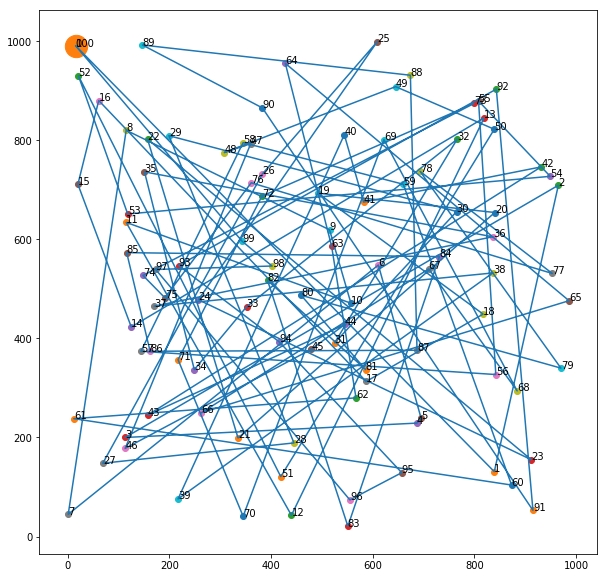

In [9]:
x = generate_random_num(100, 1, 1000)
y = generate_random_num(100, 1, 1000)
data = np.concatenate((x,y), axis = 1)
end_point = np.asarray(data[0]).reshape(1,2)
data = np.concatenate((data,end_point), axis = 0)

x1 = [x[0] for x in data]
y1 = [x[1] for x in data]

plt.figure(figsize=(10,10))
for i in range(len(data)):
    plt.scatter(data[i][0], data[i][1])
    plt.text(data[i][0], data[i][1], i)
    
plt.plot(x1, y1)
plt.scatter(data[0][0], data[0][1], s = 500)

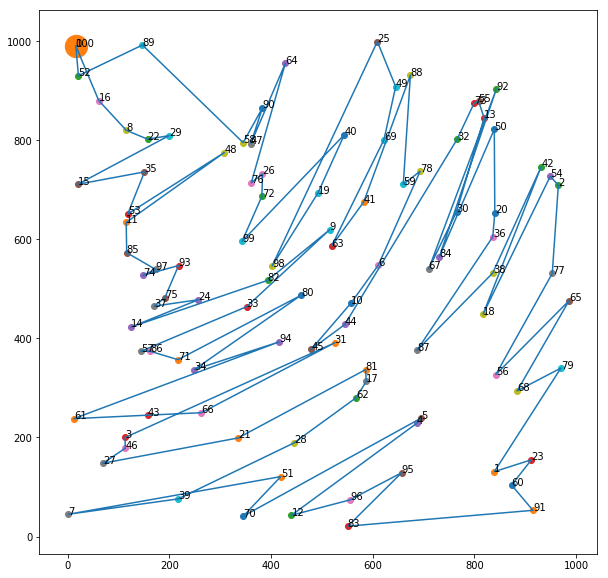

In [10]:
initial_seq = data_distance_shuffle(data)
for_plot_data = []
for i in initial_seq:
    for_plot_data.append(data[i])
        
x2 = [x[0] for x in for_plot_data]
y2 = [x[1] for x in for_plot_data]

plt.figure(figsize=(10,10))
for i in range(len(data)):
    plt.scatter(data[i][0], data[i][1])
    plt.text(data[i][0], data[i][1], i)
    
plt.plot(x2, y2)
plt.scatter(data[0][0], data[0][1], s = 500) 

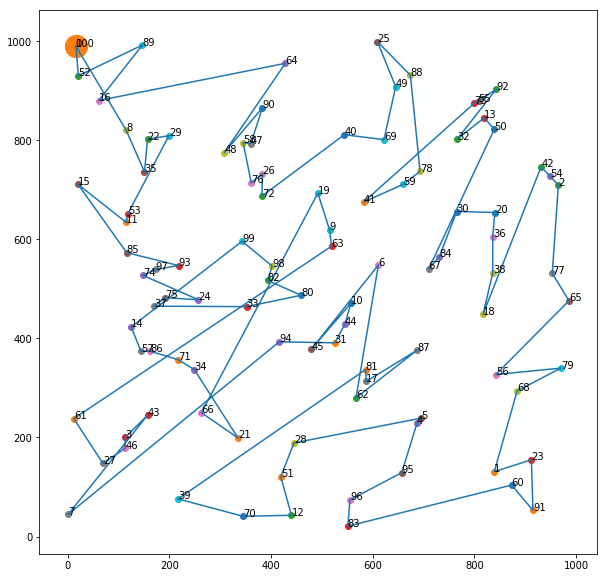

In [13]:
for i in range(20):
    forward_sequence = move_close_dist2(initial_seq, data, 100)
    reversed_sequence = forward_sequence[::-1]
    backward_sequence = move_close_dist2(reversed_sequence, data, 100)
    initial_seq = backward_sequence[::-1]

for_plot_data = []
for i in initial_seq:
    for_plot_data.append(data[i])
        
x3 = [x[0] for x in for_plot_data]
y3 = [x[1] for x in for_plot_data]

    
plt.figure(figsize=(10,10))
for i in range(len(data)):
    plt.scatter(data[i][0], data[i][1])
    plt.text(data[i][0], data[i][1], i)
    
plt.plot(x3, y3)
plt.scatter(data[0][0], data[0][1], s = 500) 

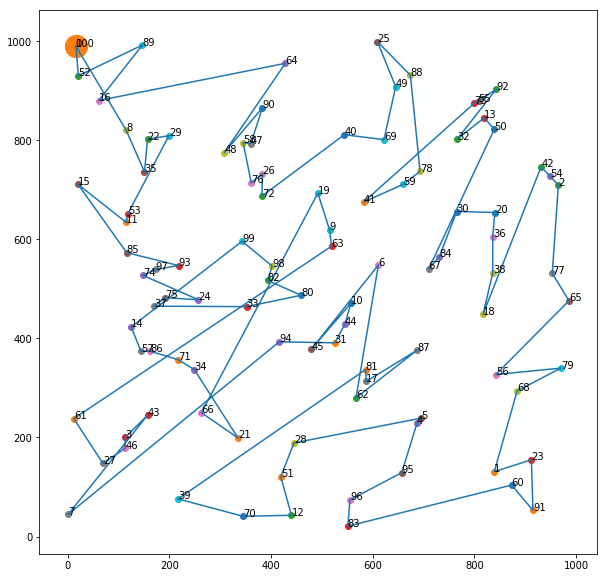

In [16]:
count = 0
k = 7
k1 = 7
for i in range(10):
    forward_sequence = batch_sequence_update(initial_seq, data, k)
    #reversed_sequence = forward_sequence[::-1]
    #initial_seq = batch_sequence_update(forward_sequence, data, k1)
    #initial_seq = backward_sequence[::-1]
    forward_sequence = initial_seq
    
new_data = []
for i in initial_seq:
    new_data.append(data[i])
        
x4 = [x[0] for x in new_data]
y4 = [x[1] for x in new_data]

plt.figure(figsize=(10,10))
for i in range(len(data)):
    plt.scatter(data[i][0], data[i][1])
    plt.text(data[i][0], data[i][1], i)

plt.plot(x4, y4)
plt.scatter(data[0][0], data[0][1], s = 500) 

In [106]:
new_seq = [0,1,2,3,4,5,6,7]
initial_seq = [0,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122]

k = 5
tenth_index = 0
for index in range(k):
    if (len(new_seq)+index+1)%10==0:
        tenth_index = initial_seq[len(new_seq)+index]
    print(tenth_index)

0
109
109
109
109


In [5]:
dist = 1000
city_prime =  False
batch_ids = 109

if batch_ids==tenth_index and city_prime==False and tenth_index != 0:
    dist = dist*1.1

else:
    dist = dist
    
dist

1100.0

In [111]:
tenth_index = 0
for index in range(10):
    if (len(new_seq)+index+1)%10==0:
        tenth_index = initial_seq[len(new_seq)+index]
        print(tenth_index)
tenth_index

109


109

In [110]:
total_distance = 0
count = 0
for i in range(33):
    if i%10 == 0:
        print('prime: ', i)
    else:
        pass
        #print('not_prime: ', i)

prime:  0
prime:  10
prime:  20
prime:  30
